<a href="https://colab.research.google.com/github/Divyacanny22/100-days-of-python/blob/master/flower_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
## import libraries

import torch
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from PIL import Image
from tqdm.notebook import tqdm

import torchvision
import torchvision.transforms as T


##Download dataset

In [71]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od

dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition/flowers'
od.download(dataset_url)
# "anbudt","key":"3610225a5f23efdcd78b253413a183b6"}

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [72]:

import os

# Look into the data directory
root_dir = './flowers-recognition'
data_dir = './flowers-recognition/flowers'
print(os.listdir(data_dir))

['rose', 'sunflower', 'tulip', 'dandelion', 'daisy']


In [73]:
# Importing shutil library to delete the folder with it's contents
import shutil

# Delete the duplicate folder
dup_dir = data_dir + '/flowers'
if os.path.exists(dup_dir) and os.path.isdir(dup_dir):
    shutil.rmtree(dup_dir)

# Look into the new data directory 
print(os.listdir(data_dir))


['rose', 'sunflower', 'tulip', 'dandelion', 'daisy']


In [74]:
def rename_files(root_dir):
    classes = os.listdir(root_dir)
    for classes in classes:
        for file in os.listdir(root_dir + '/' + classes): 
            if file.endswith('jpg'):
                os.rename((root_dir + '/' + classes + '/' + file),(root_dir + '/' + classes + '/' + classes + "_" + file))

rename_files(data_dir)

## Preparing dataset

In [69]:
#import os
from torch.utils.data import Dataset
from PIL import Image

def parse_species(fname):
    parts = fname.split('_')
    return parts[0]

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FlowersDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.files = []
        self.classes = [fname for fname in os.listdir(root_dir) if fname != 'flowers']
        for classes in self.classes:                         
            for file in os.listdir(root_dir + '/' + classes): 
                if file.endswith('jpg'):
                    self.files.append(file)
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        species = parse_species(fname)
        fpath = os.path.join(self.root_dir, species, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(species)
        return img, class_idx


## Transform

In [75]:
import torchvision.transforms as T

img_size = 64
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transform = T.Compose([T.Resize((img_size, img_size)),
                       T.RandomCrop(64, padding=4, padding_mode='reflect'),
                       T.RandomHorizontalFlip(),
                       T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                       T.ToTensor(),
                       T.Normalize(*stats,inplace=True)])
dataset = FlowersDataset(data_dir, transform=transform)


In [76]:
len(dataset)

4317

In [77]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: rose (0)


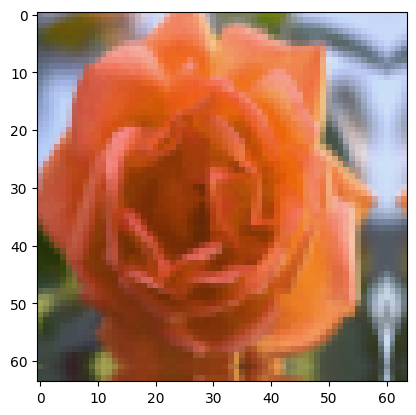

In [87]:
show_image(*dataset[5]);


## Training & validation sets

In [88]:
from torch.utils.data import random_split

random_seed = 43
torch.manual_seed(random_seed)

val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [89]:
train_ds, valid_ds= random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

## Data  Loader

In [95]:
from torch.utils.data import DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [96]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

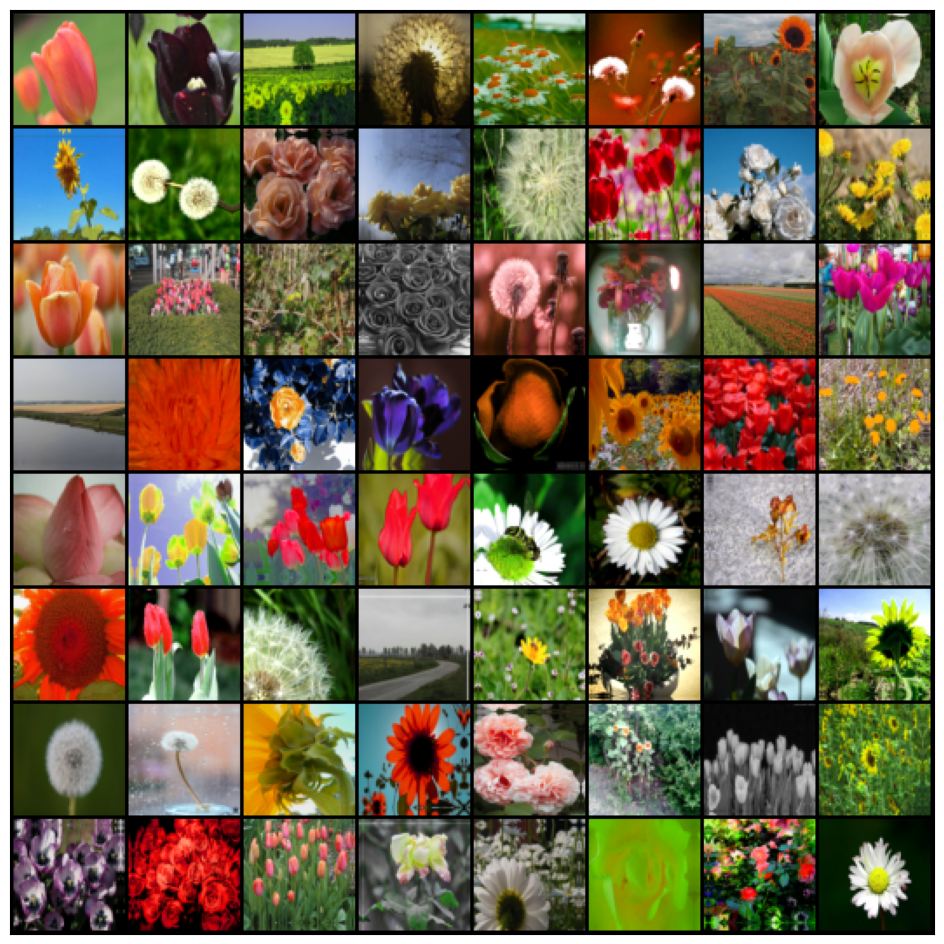

In [98]:
show_batch(train_dl)

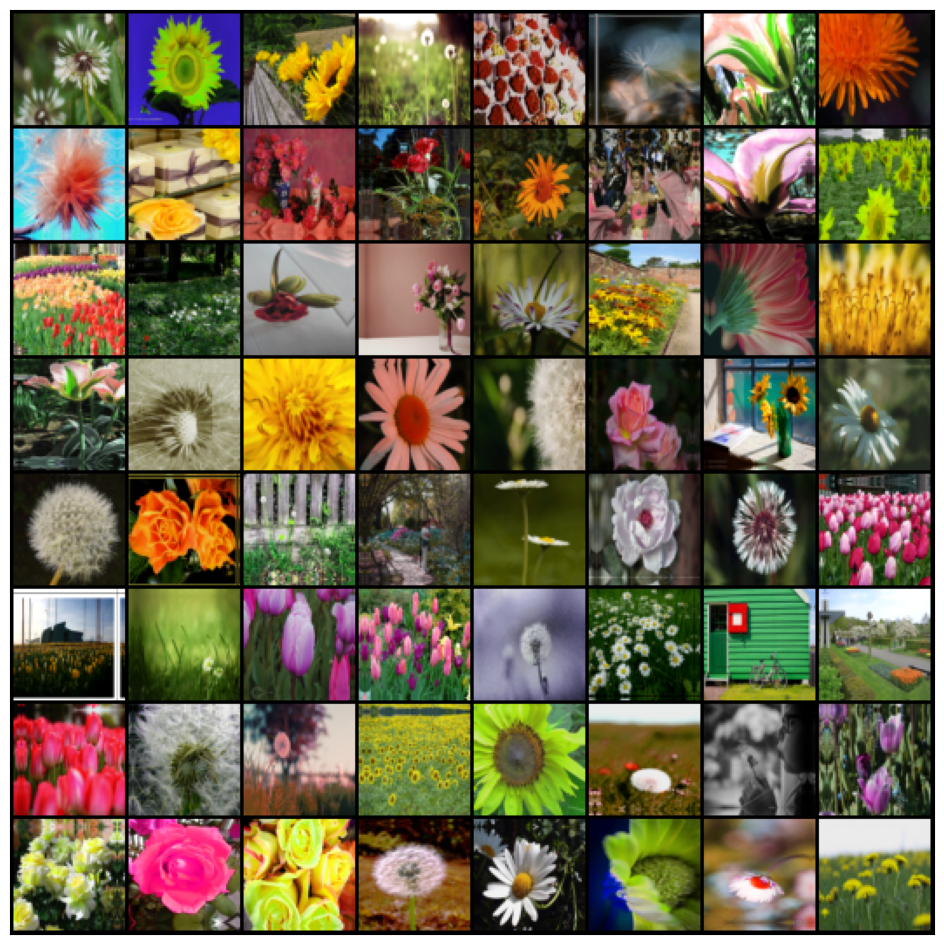

In [99]:
show_batch(valid_dl)

## Using a GPU

In [101]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [103]:
# Setup device-agnostic code
device = get_default_device()
device

device(type='cpu')

In [104]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## More Architecture

In [105]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [106]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)   
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)    
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))   
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),     
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))    
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [107]:
model = to_device(ResNet9(3, 5), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

In [108]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [109]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 1.6052831411361694, 'val_acc': 0.2653340995311737}]

In [110]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [111]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0],last_lr: 0.00275, train_loss: 1.4581, val_loss: 1.5459, val_acc: 0.5337


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00758, train_loss: 1.2977, val_loss: 2.8446, val_acc: 0.4093


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.01000, train_loss: 1.3657, val_loss: 2.1694, val_acc: 0.4742


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00950, train_loss: 1.4045, val_loss: 1.2643, val_acc: 0.5905


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00812, train_loss: 1.2565, val_loss: 1.1046, val_acc: 0.6169


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00611, train_loss: 1.1731, val_loss: 0.9573, val_acc: 0.6471


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00389, train_loss: 1.0091, val_loss: 0.7833, val_acc: 0.7270


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00188, train_loss: 0.8449, val_loss: 0.8786, val_acc: 0.6831


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00050, train_loss: 0.6869, val_loss: 0.6974, val_acc: 0.7579


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00000, train_loss: 0.6597, val_loss: 0.6678, val_acc: 0.7772
CPU times: user 1h 52min 14s, sys: 13min 30s, total: 2h 5min 44s
Wall time: 2h 7min 55s


In [112]:
train_time='2:42'

In [113]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


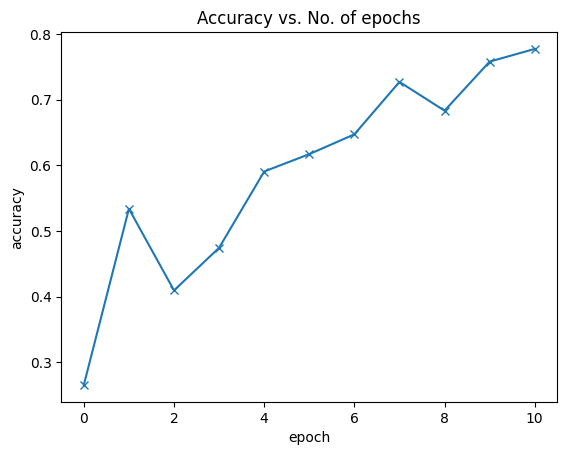

In [114]:
plot_accuracies(history)

In [115]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

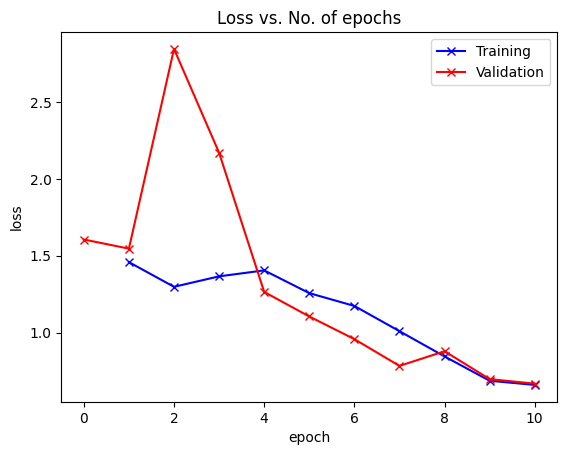

In [116]:
plot_losses(history)


In [117]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


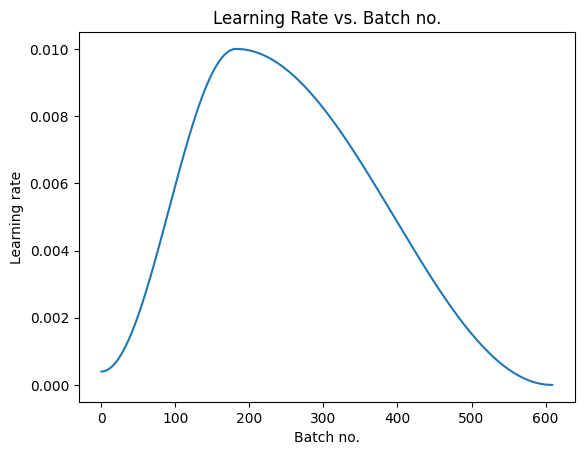

In [118]:
plot_lrs(history)

## Testing the Model

In [119]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]


Label: tulip , Predicted: tulip


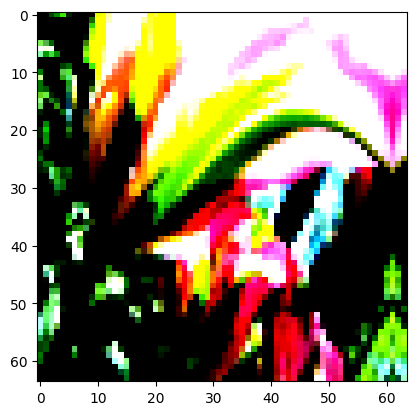

In [120]:
img, label = valid_ds[6]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: sunflower , Predicted: sunflower


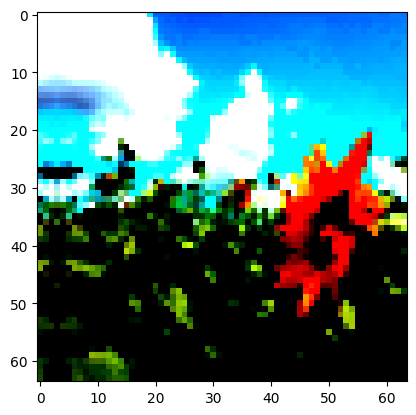

In [121]:
img, label = valid_ds[156]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: rose , Predicted: rose


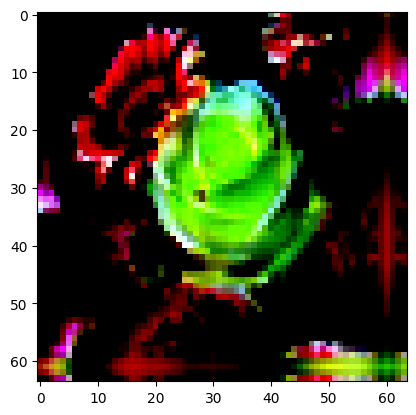

In [122]:
img, label = valid_ds[388]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))